# Supervised, Multi-Class Classification of Scam Reports: Experiment 3 (Classification with Class Balanced with SMOTE)

The objective of this Python notebook is train three deep learning models, namely the RNN, LSTM and Bi-LSTM on the text data corresponding to the top six scam types, both with and without the GloVe pre-trained word embeddings. The number of classes for each scam type will be "balanced" using the Synthetic Minority Over-Sampling Technique (SMOTE). This notebook also evaluates the trained models on the test set. 

## Import the necessary libraries

In [3]:
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk import word_tokenize, sent_tokenize
from collections import Counter
import tensorflow as tf
from keras.models import Sequential, Model
from keras import layers, models
from keras.layers import Input, Embedding, LSTM, SimpleRNN, Dense, Concatenate, Bidirectional, Dropout, GRU
from keras.utils.np_utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.utils import plot_model
from keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
import nltk
import random
import re
import pickle
import timeit
import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
%pprint

Pretty printing has been turned OFF


## Mount drive and change to correct directory

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

In [5]:
# cd /content/drive/My Drive/Dissertation

## Define functions

In [6]:
def plot_confusion_matrix(cm,
                        classes,
                        path,
                        normalize=False,
                        title='Confusion Matrix',
                        cmap=plt.cm.Blues):
    
    """This function prints and plots a confusion matrix. 
    Normalised confusion matrix can be applied by setting `normalize=True'."""
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = 'Confusion Matrix with Normalised Values' 
    else:
        title = 'Confusion Matrix with Absolute Values'
    
    plt.figure(figsize=(10, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    
    # Specify the tick marks and axis text
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    
    # The data formatting
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Print the text of the matrix, adjusting text colour for display
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")
    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.xlim(-0.5, len(classes)-0.5)
    plt.ylim(len(classes)-0.5, -0.5)
    plt.savefig(path)
    plt.show()

In [7]:
def get_glove_vectors(filename="Data/glove.6B.200d.txt"):    
    
    """This function gets all GloVe word embeddings from a specified pre-trained model."""
    
    glove_vector_dict = {}
    with open(filename, encoding="utf8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = values[1:]
            glove_vector_dict[word] = np.asarray(coefs, dtype='float32')
            
    return glove_vector_dict

In [8]:
def filter_glove(vocabulary_dict, glove_dict, embedding_dim=300):
    
    """This function creates a matrix to store the GloVe word embeddings based on a dictionary of vocabulary."""
 
    embedding_matrix = np.zeros((len(vocabulary_dict)+1, embedding_dim))
    hits = 0
    misses = 0
    
    for word, i in vocabulary_dict.items():
        embedding_vector = glove_dict.get(word)
        if embedding_vector is not None:
            # words not found in the glove_dict will be all-zeros
            embedding_matrix[i] = embedding_vector
            hits += 1
        else:
            misses += 1
            
    print("Converted %d words (%d misses)" % (hits, misses))        
    return embedding_matrix, hits, misses


In [9]:
def read_csv(path):
    
    """This function reads a CSV file from a specified filepath, while preserving the data types of each variable.
    Source: https://stackoverflow.com/questions/50047237/how-to-preserve-dtypes-of-dataframes-when-using-to-csv/50051542#50051542"""
    
    # Read types first line of csv
    dtypes = {key:value for (key,value) in pd.read_csv(path, nrows=1).iloc[0].to_dict().items() if 'date' not in value}

    parse_dates = [key for (key,value) in pd.read_csv(path, 
                   nrows=1).iloc[0].to_dict().items() if 'date' in value]
    
    # Read the rest of the lines with the types from above
    return pd.read_csv(path, dtype=dtypes, parse_dates=parse_dates, skiprows=[1])

In [10]:
def k_fold_cv(X_train, Y_train, k=5, model_name="RNN", filedir="Models/Scam_Classifier_1/"):

    """This function performs k-fold cross-validation given a particular model and saves the model at a specified file path."""    
    
    print("\nPerforming a " + str(k) + "-fold cross-validation for " + model_name + " model")
    
    start = timeit.default_timer()
    
    # define k-fold cross validation test 
    kfold = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    folds = list(kfold.split(X_train, Y_train))

    cvscores = []
    for j, (train_idx, test_idx) in enumerate(folds):
        print('\nFold', j+1, "...\n")
        X_train_cv = X_train[train_idx]
        Y_train_cv = to_categorical([list(Y_train)[i] for i in tuple(train_idx)])
        X_test_cv = X_train[test_idx]
        Y_test_cv = to_categorical([list(Y_train)[i] for i in tuple(test_idx)])

        prefix = str(model_name)
        fold = "-fold-" + str(j+1)
        model_func = "create_" + model_name + "_model()"
        model = eval(model_func)
        checkpoint_path = filedir + "best-" + prefix + fold + ".h5"

        # Define early stopping
        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
        mc = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', mode='min', verbose=1, save_best_only=True, period=1)

        # Train the model
        model.fit(X_train_cv, Y_train_cv, epochs=30, batch_size=16, callbacks=[es, mc], verbose=1, validation_data = (X_test_cv, Y_test_cv))

        # Load best model and evaluate
        best_model = load_model(checkpoint_path)
        _, acc = best_model.evaluate(X_test_cv, Y_test_cv, batch_size=16, verbose=0)
        cvscores.append(acc*100)

    exec_time = timeit.default_timer() - start
    print("\nAverage Validation Accuracy: %.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))    
    print("Total Training Time (secs):", round(exec_time, 4))

    return cvscores, exec_time

In [11]:
def k_fold_cv_glove(X_train, Y_train, k=5, model_name="RNN", filedir="Models/Scam_Classifier_1/"):

    """This function performs k-fold cross-validation given a particular model with GloVe embeddings and saves the model at a specified file path."""    
    
    print("\nPerforming a " + str(k) + "-fold cross-validation for " + model_name + " model")
    
    start = timeit.default_timer()
    
    # define k-fold cross validation test 
    kfold = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    folds = list(kfold.split(X_train, Y_train))

    cvscores = []
    for j, (train_idx, test_idx) in enumerate(folds):
        print('\nFold', j+1, "...\n")
        X_train_cv = X_train[train_idx]
        Y_train_cv = to_categorical([list(Y_train)[i] for i in tuple(train_idx)])
        X_test_cv = X_train[test_idx]
        Y_test_cv = to_categorical([list(Y_train)[i] for i in tuple(test_idx)])

        prefix = str(model_name)
        fold = "-fold-" + str(j+1)
        model_func = "create_" + model_name + "_model_glove()"
        model = eval(model_func)
        checkpoint_path = filedir + "best-" + prefix + fold + ".h5"

        # Define early stopping
        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
        mc = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', mode='min', verbose=1, save_best_only=True, period=1)

        # Train the model
        model.fit(X_train_cv, Y_train_cv, epochs=30, batch_size=16, callbacks=[es, mc], verbose=1, validation_data = (X_test_cv, Y_test_cv))

        # Load best model and evaluate
        best_model = load_model(checkpoint_path)
        _, acc = best_model.evaluate(X_test_cv, Y_test_cv, batch_size=16, verbose=0)
        cvscores.append(acc*100)

    exec_time = timeit.default_timer() - start
    print("\nAverage Validation Accuracy: %.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))    
    print("Total Training Time (secs):", round(exec_time, 4))

    return cvscores, exec_time

In [12]:
def create_RNN_model():
   
    """This function defines the architecture of a RNN model without GloVe word embeddings."""
   
    model = Sequential(name="Scam Classifier with RNN")
    model.add(Embedding(vocab_size, embedding_dim, input_shape=(maxlen,)))
    model.add(SimpleRNN(128, dropout=0.1, recurrent_dropout=0.1))
    model.add(Dense(num_classes, activation="softmax"))
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    
    return model

In [13]:
def create_LSTM_model():

    """This function defines the architecture of a LSTM model without GloVe word embeddings."""
    
    model = Sequential(name="Scam Classifier with LSTM")
    model.add(Embedding(vocab_size, embedding_dim, input_shape=(maxlen,)))
    model.add(LSTM(128, dropout=0.1, recurrent_dropout=0.1))
    model.add(Dense(num_classes, activation="softmax"))
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    
    return model

In [14]:
def create_BiLSTM_model():
    
    """This function defines the architecture of a BiLSTM model without GloVe word embeddings."""
    
    model = Sequential(name="Scam Classifier with BiLSTM")
    model.add(Embedding(vocab_size, embedding_dim, input_shape=(maxlen,)))
    model.add(Bidirectional(LSTM(128, dropout=0.1, recurrent_dropout=0.1)))
    model.add(Dense(num_classes, activation="softmax"))
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    
    return model

In [15]:
def create_RNN_model_glove():

    """This function defines the architecture of a RNN model with GloVe word embeddings."""
    
    model = Sequential(name="Scam Classifier with RNN and GloVe")
    model.add(Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], trainable=False, input_shape=(maxlen,)))
    model.add(SimpleRNN(128, dropout=0.1, recurrent_dropout=0.1))
    model.add(Dense(num_classes, activation="softmax"))
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    
    return model

In [16]:
def create_LSTM_model_glove():

    """This function defines the architecture of a LSTM model with GloVe word embeddings."""
    
    model = Sequential(name="Scam Classifier with LSTM and GloVe")
    model.add(Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], trainable=False, input_shape=(maxlen,)))
    model.add(LSTM(128, dropout=0.1, recurrent_dropout=0.1))
    model.add(Dense(num_classes, activation="softmax"))
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    
    return model

In [17]:
def create_BiLSTM_model_glove():
    
    """This function defines the architecture of a BiLSTM model with GloVe word embeddings."""
    
    model = Sequential(name="Scam Classifier with BiLSTM and GloVe")
    model.add(Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], trainable=False, input_shape=(maxlen,)))
    model.add(Bidirectional(LSTM(128, dropout=0.1, recurrent_dropout=0.1)))
    model.add(Dense(num_classes, activation="softmax"))
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    
    return model

In [18]:
def data_top_n(data, n):
    
    """This function takes a scam dataframe and returns records corresponding to the top n categories."""

    count_df = data[['scam_type','lemmatised']].groupby('scam_type').aggregate({'lemmatised':'count'}).reset_index().sort_values('lemmatised',ascending=False)
    top_n_scam_types = list(count_df.nlargest(n, 'lemmatised').scam_type)
    
    return data[data['scam_type'].isin(top_n_scam_types)]

## Prepare the data

In [19]:
# Import dataset
data = read_csv("Data/scam_data_4.csv")[['preprocessed_text', 'lemmatised', 'len_preprocessed_text', 'len_lemmatised', 'scam_type']]

# Convert scam type from category to string data type
data.scam_type = data.scam_type.astype('str')

# Extract records corresponding to top six scam types
data = data_top_n(data=data, n=6)

# Sanity check
data.scam_type.value_counts()

Impersonation Scam       1611
Online Purchase Scam      812
Internet Love Scam        707
Investment Scam           264
Home/Room Rental Scam     227
Credit-for-Sex Scam       197
Name: scam_type, dtype: int64

In [20]:
# Convert scam types into numbers
data.scam_type = data.scam_type.astype('category') 
data['scam_type_ids'] = data.scam_type.cat.codes

# Sanity check
data.scam_type_ids.unique()

array([2, 1, 3, 0, 5, 4], dtype=int8)

In [19]:
# Save a dictionary mapping index to scam types
scam_type_cat_mapping = dict(enumerate(data.scam_type.cat.categories))
a_file = open("Data/scam_type_cat_mapping.pkl", "wb")
pickle.dump(scam_type_cat_mapping, a_file)
a_file.close()

## Without pre-trained GloVe word embeddings

### Preparing training data

In [22]:
X = data.lemmatised
y = data.scam_type_ids
X_train, X_test, Y_train, Y_test = train_test_split(X, y, stratify=y, test_size=0.20, random_state=42)
X_true = X_test
Y_true = Y_test

num_words = 8000
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(list(X_train))
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1
print("\n==> vocab_size: ", vocab_size)

# Set maximum length as the 80th percentile of the length of text in the dataset
maxlen = int(data.len_lemmatised.quantile(0.80))
print("==> maxlen: ", maxlen)

num_classes = len(data.scam_type.unique())
embedding_dim = 300
print("==> embedding_dim: ", embedding_dim)

X_train = pad_sequences(X_train, maxlen=maxlen)
X_test = pad_sequences(X_test, maxlen=maxlen)

# Save the tokenizer
with open('Tokenizer/scam_classifier_smote_tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)


==> vocab_size:  9095
==> maxlen:  55
==> embedding_dim:  300


### Visualise the models

#### RNN

In [24]:
model = create_RNN_model()
model.summary()

Model: "Scam Classifier with RNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 55, 300)           2728500   
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 128)               54912     
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 774       
Total params: 2,784,186
Trainable params: 2,784,186
Non-trainable params: 0
_________________________________________________________________


#### LSTM

In [42]:
model = create_LSTM_model()
model.summary()

Model: "Scam Classifier with LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 55, 300)           2727600   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               219648    
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 774       
Total params: 2,948,022
Trainable params: 2,948,022
Non-trainable params: 0
_________________________________________________________________


#### BiLSTM

In [25]:
model = create_BiLSTM_model()
model.summary()

Model: "Scam Classifier with BiLSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 55, 300)           2728500   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               439296    
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 1542      
Total params: 3,169,338
Trainable params: 3,169,338
Non-trainable params: 0
_________________________________________________________________


### Training the models with 5-fold cross-validation

In [21]:
# Sampling with SMOTE
n = 400
oversample = SMOTE(sampling_strategy={0: n, 1: n, 4: n})
undersample = RandomUnderSampler(sampling_strategy={2: n, 5: n, 3: n})
steps = [('o', oversample), ('u', undersample)]
pipeline = Pipeline(steps=steps)
X_train, Y_train = pipeline.fit_resample(X_train, Y_train)

model_dict = {1: "RNN", 2: "LSTM", 3: "BiLSTM"}
acc_scores = []
training_time = []

for i, m in model_dict.items():
    model_name = model_dict.get(i)
    acc, time = k_fold_cv(X_train, Y_train, k=5, model_name=model_name, filedir="Models/Scam_Classifier_SMOTE/")
    acc_scores.append(acc)
    training_time.append(time)

j = len(acc_scores[0])   

# Initialise an empty dataframe
df = pd.DataFrame()
for i in range(j):
    fold = [scores[i] for scores in acc_scores]
    df2 = pd.DataFrame({"fold " + str(i):fold})
    df = pd.concat([df, df2], axis=1)
df3 = pd.DataFrame({"time": training_time})    
df = pd.concat([df, df3], axis=1)
df = df.set_index(pd.Series(["RNN", "LSTM", "BiLSTM"]))
print("End of Experiment")
df


==> vocab_size:  9092
==> maxlen:  55
==> embedding_dim:  200

Performing a 5-fold cross-validation for RNN model

Fold 1 ...



/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

Train on 1920 samples, validate on 480 samples
Epoch 1/30
1920/1920 [==============================] - 10s 5ms/step - loss: 1.8331 - accuracy: 0.1828 - val_loss: 1.7739 - val_accuracy: 0.2229

Epoch 00001: val_loss improved from inf to 1.77394, saving model to Models/Scam_Classifier_SMOTE/best-RNN-fold-1.h5
Epoch 2/30
1920/1920 [==============================] - 8s 4ms/step - loss: 1.6324 - accuracy: 0.3562 - val_loss: 1.7313 - val_accuracy: 0.2521

Epoch 00002: val_loss improved from 1.77394 to 1.73127, saving model to Models/Scam_Classifier_SMOTE/best-RNN-fold-1.h5
Epoch 3/30
1920/1920 [==============================] - 8s 4ms/step - loss: 1.2218 - accuracy: 0.6115 - val_loss: 1.7115 - val_accuracy: 0.3000

Epoch 00003: val_loss improved from 1.73127 to 1.71148, saving model to Models/Scam_Classifier_SMOTE/best-RNN-fold-1.h5
Epoch 4/30
1920/1920 [==============================] - 8s 4ms/step - loss: 0.7342 - accuracy: 0.8057 - val_loss: 1.7582 - val_accuracy: 0.3187

Epoch 00004: val

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 1920 samples, validate on 480 samples
Epoch 1/30
1920/1920 [==============================] - 15s 8ms/step - loss: 1.6118 - accuracy: 0.3375 - val_loss: 1.4425 - val_accuracy: 0.5125

Epoch 00001: val_loss improved from inf to 1.44248, saving model to Models/Scam_Classifier_SMOTE/best-LSTM-fold-1.h5
Epoch 2/30
1920/1920 [==============================] - 14s 7ms/step - loss: 1.0652 - accuracy: 0.6323 - val_loss: 1.1190 - val_accuracy: 0.5750

Epoch 00002: val_loss improved from 1.44248 to 1.11904, saving model to Models/Scam_Classifier_SMOTE/best-LSTM-fold-1.h5
Epoch 3/30
1920/1920 [==============================] - 14s 7ms/step - loss: 0.5756 - accuracy: 0.8177 - val_loss: 1.1570 - val_accuracy: 0.5958

Epoch 00003: val_loss did not improve from 1.11904
Epoch 4/30
1920/1920 [==============================] - 14s 7ms/step - loss: 0.3254 - accuracy: 0.9036 - val_loss: 1.1263 - val_accuracy: 0.6208

Epoch 00004: val_loss did not improve from 1.11904
Epoch 5/30
1920/1920 [=======

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 1920 samples, validate on 480 samples
Epoch 1/30
1920/1920 [==============================] - 29s 15ms/step - loss: 1.5201 - accuracy: 0.3750 - val_loss: 1.2770 - val_accuracy: 0.5521

Epoch 00001: val_loss improved from inf to 1.27700, saving model to Models/Scam_Classifier_SMOTE/best-BiLSTM-fold-1.h5
Epoch 2/30
1920/1920 [==============================] - 28s 14ms/step - loss: 1.0106 - accuracy: 0.6339 - val_loss: 1.1638 - val_accuracy: 0.5667

Epoch 00002: val_loss improved from 1.27700 to 1.16384, saving model to Models/Scam_Classifier_SMOTE/best-BiLSTM-fold-1.h5
Epoch 3/30
1920/1920 [==============================] - 28s 14ms/step - loss: 0.6640 - accuracy: 0.7677 - val_loss: 1.1648 - val_accuracy: 0.5979

Epoch 00003: val_loss did not improve from 1.16384
Epoch 4/30
1920/1920 [==============================] - 28s 15ms/step - loss: 0.4186 - accuracy: 0.8729 - val_loss: 1.1333 - val_accuracy: 0.6354

Epoch 00004: val_loss improved from 1.16384 to 1.13325, saving model to 

,fold 0,fold 1,fold 2,fold 3,fold 4,time
RNN,30.000001,28.958333,34.375000,33.125001,32.708332,544.455898
LSTM,57.499999,63.541669,63.958335,57.083333,60.416669,886.897625
BiLSTM,63.541669,68.124998,68.333334,61.666667,65.416664,1930.013071


### Save results as a CSV file

In [22]:
df.to_csv("Results/scam_classification_smote_no_pretrained.csv")

## With pre-trained GloVe word embeddings (300D)

### Preparing the GloVe word embeddings

In [27]:
glove_embedding_dict = get_glove_vectors(filename="Data/glove.6B.300d.txt")
embedding_matrix, h, m = filter_glove(tokenizer.word_index, glove_embedding_dict, embedding_dim=300)
print(embedding_matrix.shape)

Converted 7454 words (1640 misses)
(9095, 300)


### Preparing training data

In [28]:
X = data.lemmatised
y = data.scam_type_ids
X_train, X_test, Y_train, Y_test = train_test_split(X, y, stratify=y, test_size=0.20, random_state=42)
X_true = X_test
Y_true = Y_test

num_words = 8000
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(list(X_train))
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1
print("\n==> vocab_size: ", vocab_size)

# Set maximum length as the 80th percentile of the length of text in the dataset
maxlen = int(data.len_lemmatised.quantile(0.80))
print("==> maxlen: ", maxlen)

num_classes = len(data.scam_type.unique())
embedding_dim = 300
print("==> embedding_dim: ", embedding_dim)

X_train = pad_sequences(X_train, maxlen=maxlen)
X_test = pad_sequences(X_test, maxlen=maxlen)


==> vocab_size:  9095
==> maxlen:  55
==> embedding_dim:  300


### Visualise the models

#### RNN

In [29]:
model = create_RNN_model_glove()
model.summary()

Model: "Scam Classifier with RNN and GloVe"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 55, 300)           2728500   
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 128)               54912     
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 774       
Total params: 2,784,186
Trainable params: 55,686
Non-trainable params: 2,728,500
_________________________________________________________________


#### LSTM

In [30]:
model = create_LSTM_model_glove()
model.summary()

Model: "Scam Classifier with LSTM and GloVe"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 55, 300)           2728500   
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               219648    
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 774       
Total params: 2,948,922
Trainable params: 220,422
Non-trainable params: 2,728,500
_________________________________________________________________


#### BiLSTM

In [32]:
model = create_BiLSTM_model_glove()
model.summary()

Model: "Scam Classifier with BiLSTM and GloVe"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 55, 300)           2728500   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 256)               439296    
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 1542      
Total params: 3,169,338
Trainable params: 440,838
Non-trainable params: 2,728,500
_________________________________________________________________


### Training the models with 5-fold cross-validation

In [25]:
# Sampling with SMOTE
n = 400
oversample = SMOTE(sampling_strategy={0: n, 1: n, 4: n})
undersample = RandomUnderSampler(sampling_strategy={2: n, 5: n, 3: n})
steps = [('o', oversample), ('u', undersample)]
pipeline = Pipeline(steps=steps)
X_train, Y_train = pipeline.fit_resample(X_train, Y_train)

model_dict = {1: "RNN", 2: "LSTM", 3: "BiLSTM"}
acc_scores = []
training_time = []

for i, m in model_dict.items():
    model_name = model_dict.get(i)
    acc, time = k_fold_cv_glove(X_train, Y_train, k=5, model_name=model_name, filedir="Models/Scam_Classifier_SMOTE_Glove/")
    acc_scores.append(acc)
    training_time.append(time)

j = len(acc_scores[0])   

# Initialise an empty dataframe
df_glove = pd.DataFrame()
for i in range(j):
    fold = [scores[i] for scores in acc_scores]
    df2 = pd.DataFrame({"fold " + str(i):fold})
    df_glove = pd.concat([df_glove, df2], axis=1)
df3 = pd.DataFrame({"time": training_time})    
df_glove = pd.concat([df_glove, df3], axis=1)
df_glove = df_glove.set_index(pd.Series(["RNN", "LSTM", "BiLSTM"]))
print("End of experiment")
df_glove


==> vocab_size:  9092
==> maxlen:  55
==> embedding_dim:  300

Performing a 5-fold cross-validation for RNN model

Fold 1 ...



/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

Train on 1920 samples, validate on 480 samples
Epoch 1/30
1920/1920 [==============================] - 6s 3ms/step - loss: 1.8059 - accuracy: 0.2422 - val_loss: 1.6017 - val_accuracy: 0.3208

Epoch 00001: val_loss improved from inf to 1.60172, saving model to Models/Scam_Classifier_SMOTE_Glove/best-RNN-fold-1.h5
Epoch 2/30
1920/1920 [==============================] - 5s 3ms/step - loss: 1.4302 - accuracy: 0.4380 - val_loss: 1.5808 - val_accuracy: 0.3438

Epoch 00002: val_loss improved from 1.60172 to 1.58078, saving model to Models/Scam_Classifier_SMOTE_Glove/best-RNN-fold-1.h5
Epoch 3/30
1920/1920 [==============================] - 5s 3ms/step - loss: 1.3400 - accuracy: 0.4891 - val_loss: 1.6506 - val_accuracy: 0.3354

Epoch 00003: val_loss did not improve from 1.58078
Epoch 4/30
1920/1920 [==============================] - 6s 3ms/step - loss: 1.1550 - accuracy: 0.5703 - val_loss: 1.6770 - val_accuracy: 0.3792

Epoch 00004: val_loss did not improve from 1.58078
Epoch 5/30
1920/1920 [=

,fold 0,fold 1,fold 2,fold 3,fold 4,time
RNN,34.375000,34.166667,38.749999,37.291667,34.791666,362.857648
LSTM,66.666669,71.875000,65.625000,64.166665,67.500001,1046.278871
BiLSTM,64.166665,66.458333,66.666669,67.708331,66.666669,1717.309208


### Save results as a CSV file

In [26]:
df_glove.to_csv("Results/scam_classification_smote_glove.csv")

## Evaluating on test set

### Load the results

In [33]:
df3 = pd.read_csv("Results/scam_classification_smote_no_pretrained.csv")
df3.columns = ['model', '1', '2', '3', '4', '5', 'time']
df3['mode'] = 3 # for SMOTE
df3['combi'] = 5
df3['glove'] = 'N'

In [34]:
df3g = pd.read_csv("Results/scam_classification_smote_glove.csv")
df3g.columns = ['model', '1', '2', '3', '4', '5', 'time']
df3g['mode'] = 3 # for SMOTE
df3g['combi'] = 6
df3g['glove'] = 'Y'

In [35]:
results_df = pd.concat([df3, df3g], axis=0)
results_df['mean_acc'] = round(results_df.drop(columns=['model', 'time', 'mode', 'combi', 'glove']).mean(axis=1), 1)
results_df['time'] = round(results_df['time'])
results_df['fold_max'] = results_df[['1', '2', '3', '4', '5']].idxmax(axis=1)
results_df = results_df[['model',  'combi', 'mode', 'glove', 'fold_max','mean_acc', 'time']]
results_df

,model,combi,mode,glove,fold_max,mean_acc,time
0,RNN,5,3,N,5,34.2,522.0
1,LSTM,5,3,N,2,65.1,945.0
2,BiLSTM,5,3,N,3,65.4,1704.0
0,RNN,6,3,Y,5,33.4,352.0
1,LSTM,6,3,Y,3,67.2,1026.0
2,BiLSTM,6,3,Y,3,66.9,1858.0


In [35]:
folder_list = ['Scam_Classifier_SMOTE', 'Scam_Classifier_SMOTE_Glove']

<START OF EVALUATION>

[Scam Classifier with SMOTE]

Loading best RNN model from --> Models/Scam_Classifier_SMOTE/best-RNN-fold-3.h5
Average Validation Accuracy: 31.8%
Accuracy on Test Set:	48.8%
Classification Report:

                       precision    recall  f1-score   support

  Credit-for-Sex Scam       0.14      0.15      0.15        39
Home/Room Rental Scam       0.14      0.44      0.22        45
   Impersonation Scam       0.87      0.80      0.83       322
   Internet Love Scam       0.36      0.37      0.37       142
      Investment Scam       0.20      0.23      0.21        53
 Online Purchase Scam       0.31      0.15      0.20       163

             accuracy                           0.49       764
            macro avg       0.34      0.36      0.33       764
         weighted avg       0.53      0.49      0.50       764

Classification report saved at --> Results/Classification_Reports/

Confusion Matrix:



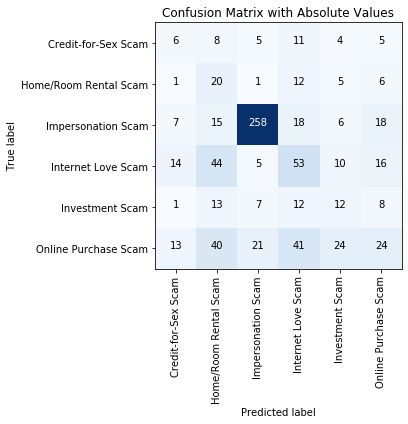

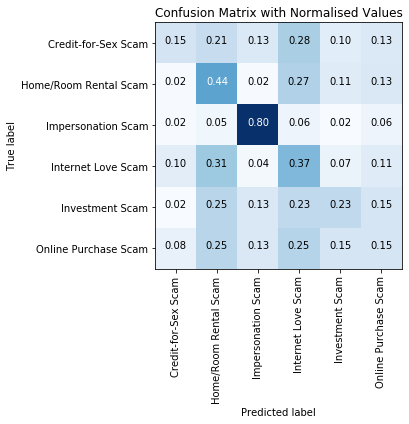

Confusion matrix saved at --> Results/Confusion_Matrix/

[Scam Classifier with SMOTE]

Loading best LSTM model from --> Models/Scam_Classifier_SMOTE/best-LSTM-fold-3.h5
Average Validation Accuracy: 60.5%
Accuracy on Test Set:	78.8%
Classification Report:

                       precision    recall  f1-score   support

  Credit-for-Sex Scam       0.85      0.28      0.42        39
Home/Room Rental Scam       0.49      0.78      0.60        45
   Impersonation Scam       0.94      0.86      0.90       322
   Internet Love Scam       0.85      0.82      0.83       142
      Investment Scam       0.40      0.51      0.45        53
 Online Purchase Scam       0.76      0.84      0.80       163

             accuracy                           0.79       764
            macro avg       0.71      0.68      0.67       764
         weighted avg       0.81      0.79      0.79       764

Classification report saved at --> Results/Classification_Reports/

Confusion Matrix:



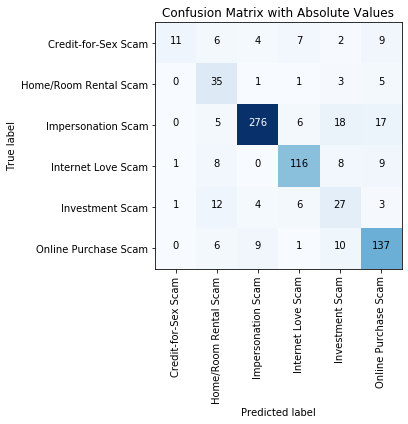

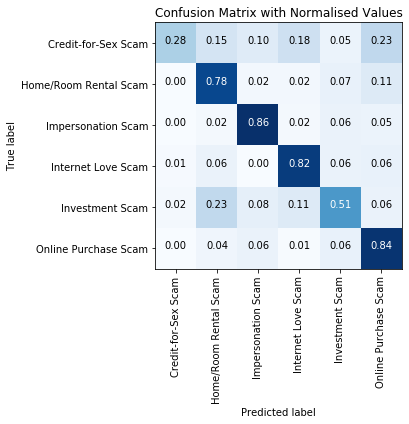

Confusion matrix saved at --> Results/Confusion_Matrix/

[Scam Classifier with SMOTE]

Loading best BiLSTM model from --> Models/Scam_Classifier_SMOTE/best-BiLSTM-fold-3.h5
Average Validation Accuracy: 65.4%
Accuracy on Test Set:	79.1%
Classification Report:

                       precision    recall  f1-score   support

  Credit-for-Sex Scam       0.47      0.69      0.56        39
Home/Room Rental Scam       0.60      0.89      0.71        45
   Impersonation Scam       0.95      0.80      0.86       322
   Internet Love Scam       0.87      0.82      0.85       142
      Investment Scam       0.45      0.72      0.55        53
 Online Purchase Scam       0.84      0.77      0.81       163

             accuracy                           0.79       764
            macro avg       0.70      0.78      0.72       764
         weighted avg       0.83      0.79      0.80       764

Classification report saved at --> Results/Classification_Reports/

Confusion Matrix:



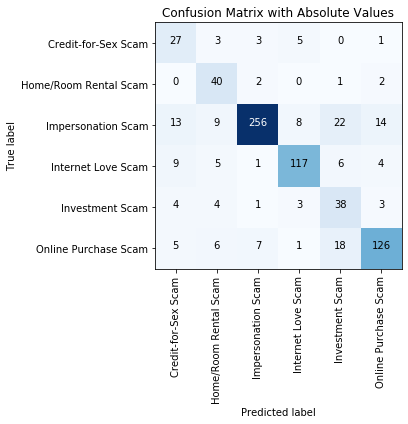

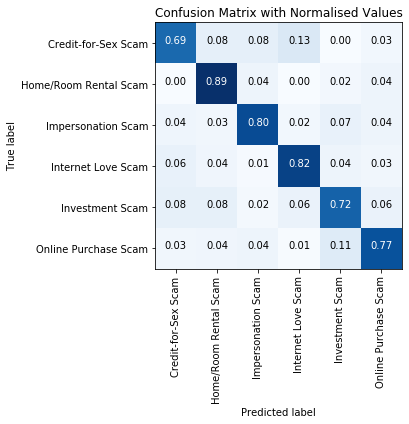

Confusion matrix saved at --> Results/Confusion_Matrix/

[Scam Classifier with SMOTE]

Loading best RNN model from --> Models/Scam_Classifier_SMOTE_Glove/best-RNN-fold-3.h5
Average Validation Accuracy: 35.9%
Accuracy on Test Set:	46.6%
Classification Report:

                       precision    recall  f1-score   support

  Credit-for-Sex Scam       0.13      0.23      0.17        39
Home/Room Rental Scam       0.08      0.13      0.10        45
   Impersonation Scam       0.84      0.75      0.80       322
   Internet Love Scam       0.34      0.27      0.30       142
      Investment Scam       0.14      0.23      0.17        53
 Online Purchase Scam       0.36      0.29      0.32       163

             accuracy                           0.47       764
            macro avg       0.31      0.32      0.31       764
         weighted avg       0.52      0.47      0.49       764

Classification report saved at --> Results/Classification_Reports/

Confusion Matrix:



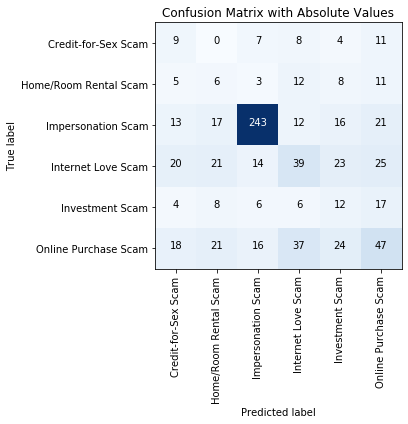

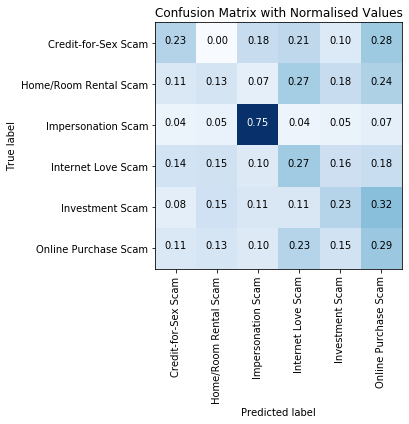

Confusion matrix saved at --> Results/Confusion_Matrix/

[Scam Classifier with SMOTE]

Loading best LSTM model from --> Models/Scam_Classifier_SMOTE_Glove/best-LSTM-fold-2.h5
Average Validation Accuracy: 67.2%
Accuracy on Test Set:	80.8%
Classification Report:

                       precision    recall  f1-score   support

  Credit-for-Sex Scam       0.47      0.72      0.57        39
Home/Room Rental Scam       0.64      0.93      0.76        45
   Impersonation Scam       0.98      0.86      0.92       322
   Internet Love Scam       0.88      0.71      0.79       142
      Investment Scam       0.48      0.75      0.59        53
 Online Purchase Scam       0.82      0.79      0.80       163

             accuracy                           0.81       764
            macro avg       0.71      0.79      0.74       764
         weighted avg       0.84      0.81      0.82       764

Classification report saved at --> Results/Classification_Reports/

Confusion Matrix:



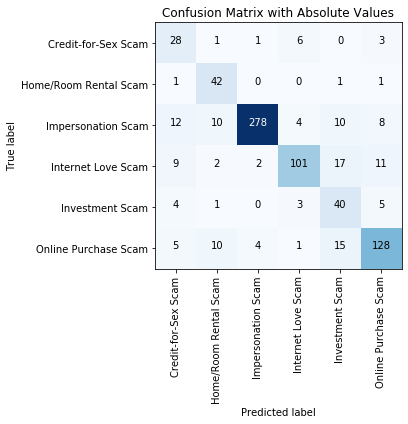

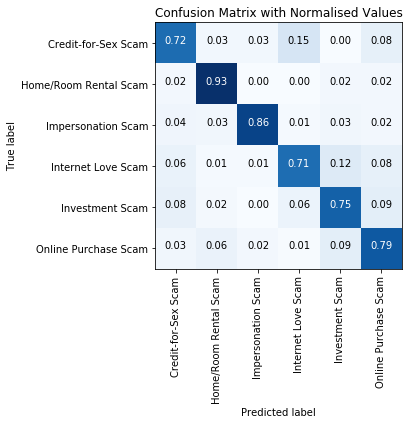

Confusion matrix saved at --> Results/Confusion_Matrix/

[Scam Classifier with SMOTE]

Loading best BiLSTM model from --> Models/Scam_Classifier_SMOTE_Glove/best-BiLSTM-fold-4.h5
Average Validation Accuracy: 66.3%
Accuracy on Test Set:	76.8%
Classification Report:

                       precision    recall  f1-score   support

  Credit-for-Sex Scam       0.41      0.79      0.54        39
Home/Room Rental Scam       0.60      0.80      0.69        45
   Impersonation Scam       0.97      0.87      0.92       322
   Internet Love Scam       0.91      0.56      0.69       142
      Investment Scam       0.40      0.75      0.52        53
 Online Purchase Scam       0.81      0.74      0.77       163

             accuracy                           0.77       764
            macro avg       0.68      0.75      0.69       764
         weighted avg       0.83      0.77      0.78       764

Classification report saved at --> Results/Classification_Reports/

Confusion Matrix:



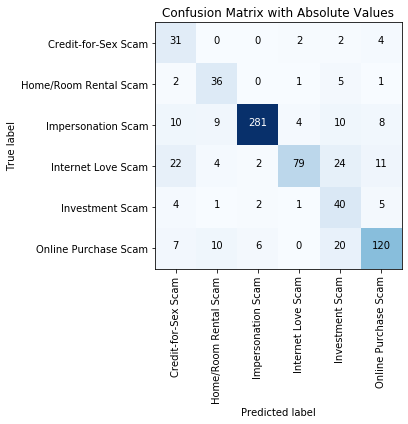

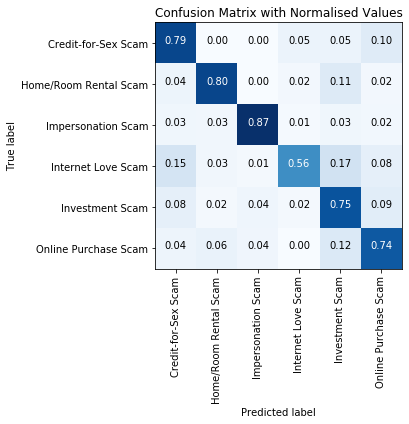

Confusion matrix saved at --> Results/Confusion_Matrix/
<END OF EVALUATION>


In [38]:
cat_mapping = dict(enumerate(data['scam_type'].cat.categories))
label_names = list(cat_mapping.values())
test_acc = []
print("<START OF EVALUATION>")

for i, j in results_df.iterrows():

    print("\n[Scam Classifier with SMOTE]\n")
  
    # Define filepath and filename to access models which gave highest validation accuracy
    filepath = "Models/" + folder_list[j['combi']-5]
    filename = "/best-" + j['model'] + "-fold-" + j['fold_max'] + ".h5"
    full_filepath = filepath + filename
    print("Loading best", j['model'], "model from -->", full_filepath)
    print("Average Validation Accuracy: %.1f%%" % j['mean_acc'])

    # Load model
    best_model = load_model(full_filepath)

    # Evaluate on the test dataset and print results
    _, acc = best_model.evaluate(X_test, to_categorical(Y_test), batch_size=16, verbose=2)
    test_acc.append(acc*100)
    print("Accuracy on Test Set:\t{0}%".format(round(acc*100,1)))
    
    # Classification report    
    pred_probabilities = best_model.predict(X_test)
    Y_pred = [np.argmax(x) for x in pred_probabilities]
    print("Classification Report:\n")
    print(classification_report(list(Y_true), Y_pred, target_names=label_names))
    
    # Save classification report as CSV file
    report = classification_report(list(Y_true), Y_pred, target_names=label_names, output_dict=True)
    filepath_cr = "Results/Classification_Reports/" 
    filename_cr = folder_list[j['combi']-5] + "-best-" + j['model'] + ".csv"
    cr_df = pd.DataFrame(report).transpose()
    cr_df.to_csv(filepath_cr + filename_cr)
    print("Classification report saved at -->", filepath_cr)

    # Print and save confusion matrix
    print("\nConfusion Matrix:\n")
    cm = confusion_matrix(list(Y_true), Y_pred)
    filepath_cm = "Results/Confusion_Matrix/"
    filename_cm = folder_list[j['combi']-5] + "-best-" + j['model'] + ".png"
    plot_confusion_matrix(cm, classes=label_names, path=filepath_cm + filename_cm)
    
    filepath_cm_norm = "Results/Confusion_Matrix_Normalised/"
    filename_cm_norm = folder_list[j['combi']-5] + "-best-normalised-" + j['model'] + ".png"
    plot_confusion_matrix(cm, normalize=True, classes=label_names, path=filepath_cm_norm + filename_cm_norm)
    print("Confusion matrix saved at -->", filepath_cm)
    print("Normalised confusion matrix saved at -->", filepath_cm_norm)

print("\n<END OF EVALUATION>")

In [39]:
# Reset index
results_df = results_df.reset_index().drop(columns='index')

# Initialise new column to store test accuracy
results_df = results_df.assign(test_acc="")

# Loop through the dataset to extract scammer name and contract from the scammer_details column
for idx, row in results_df.iterrows():
    results_df.loc[idx, 'test_acc'] = round(test_acc[idx], 1)

results_df

,model,combi,mode,glove,fold_max,mean_acc,time,test_acc
0,RNN,5,3,N,3,31.8,544.0,48.8
1,LSTM,5,3,N,3,60.5,887.0,78.8
2,BiLSTM,5,3,N,3,65.4,1930.0,79.1
3,RNN,6,3,Y,3,35.9,363.0,46.6
4,LSTM,6,3,Y,2,67.2,1046.0,80.8
5,BiLSTM,6,3,Y,4,66.3,1717.0,76.8


## Save all results as a CSV file

In [40]:
results_df.to_csv("Results/scam_classification_results_smote.csv")